In [1]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import datetime

import os
dfo=pd.DataFrame()

for f in os.listdir('./DataSource/HeyTea/')[-6:]:
    # if any(i in f for i in ['2021-12']):
    if True:
        print(f)
        date=f.split('_')[-1].split('.')[0]
        d=pd.read_csv('./DataSource/HeyTea\%s' % f)
        dfo=pd.concat([dfo,d],axis=0)

old=pd.read_hdf(r'Processed_Data/heytea.h5',key='1227')
new=pd.concat([old,dfo])
new=new.drop_duplicates()
new.to_hdf(r'Processed_Data/heytea.h5',key='1227')

df=new.copy()
c1=df['抓取时间'].isin(['抓取时间'])
df=df[~c1]
df['datetime']=pd.to_datetime(df['抓取时间'])
df['hour']=df['datetime'].dt.hour
df['date']=df['datetime'].dt.date
df['城市']=df['城市'].str.replace('市',"")

heytea.wxapp_2023-01-05.csv
heytea.wxapp_2023-01-06.csv
heytea.wxapp_2023-01-07.csv
heytea.wxapp_2023-01-08.csv
heytea.wxapp_2023-01-09.csv
heytea.wxapp_2023-01-10.csv


In [61]:
pd.pivot_table(df[df['城市']=='北京'],columns=['ID'],index=['date'],values='等待杯量',aggfunc='sum').to_clipboard()


In [2]:
#选取2022年营业大于360天的店铺
c2=df['date']>=datetime.date(2021,12,20)
df=df[c2].sort_values(by=['date'])
storelist=df.groupby(by=['hour','地址'])['ID'].count().reset_index().groupby(by='地址')['ID'].mean().reset_index()
storelist=storelist[storelist['ID']>360]['地址']
df=df[df['地址'].isin(storelist)]
df['等待杯量']=pd.to_numeric(df['等待杯量'])

ht=df.groupby(by=['date','城市'])['等待杯量'].sum().reset_index()
ht['杯量_last7d_mean']=ht.groupby('城市')['等待杯量'].transform(lambda x: x.rolling(7, 7).mean())

#计算相对22/03的平均
c1=ht['date']< datetime.date(2022,3,1)
c2=ht['date']> datetime.date(2022,2,6)
Mar_mean=ht[c1&c2].groupby('城市').mean().reset_index().sort_values(by='等待杯量')[['城市','等待杯量']].reset_index(drop=True)
Mar_mean.columns=['城市', '等待杯量_mar']
ht=ht.merge(Mar_mean,on='城市')
ht['changes_since_mar']=ht['杯量_last7d_mean']/ht['等待杯量_mar']


ht['杯量_change_WoW']=(ht['杯量_last7d_mean']/ht.groupby('城市')['杯量_last7d_mean'].transform(lambda x: x.shift(periods=7)))-1

ht['date']=ht['date'].astype('string') 

def getdt(d):
    return str(d)[-5:]
ht['dt']=ht['date'].apply(getdt)

c1=ht['date'].str.contains('2022')
ht_22=ht[c1]
ht_22=ht_22[['城市', 'dt','杯量_last7d_mean']]
ht_22=ht_22.rename(columns={'杯量_last7d_mean':'杯量_22_rolling_mean'})

c2=ht['date'].str.contains('2023')
ht_23=ht[c2]
ht_23=ht_23.merge(ht_22,how='left',on=['城市','dt'])

ht_23['ht_status']=ht_23['杯量_last7d_mean']/ht_23['杯量_22_rolling_mean']


<AxesSubplot: >

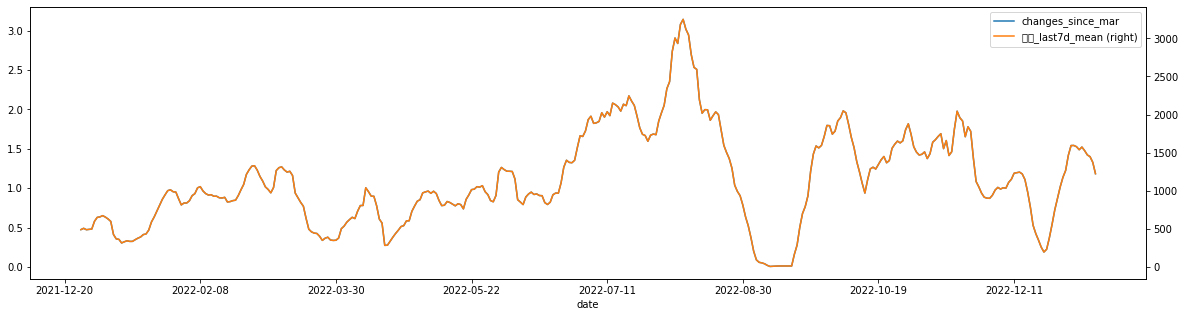

In [38]:
dfp=ht[ht['城市']=='大连']
ax = dfp.plot('date','changes_since_mar')
dfp.plot('date','杯量_last7d_mean',secondary_y=True, ax=ax, figsize=(20,5))
# dfp.plot('date','杯量_last7d_mean', figsize=(20,5))

<AxesSubplot: xlabel='date'>

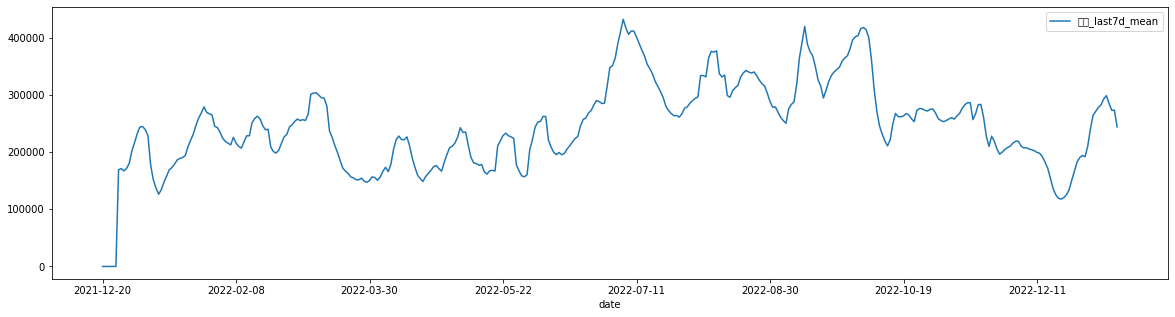

In [55]:
ht.groupby('date').sum().reset_index().plot('date','杯量_last7d_mean', figsize=(20,5))

In [24]:
# # covid rank vs. HEYTEA WoW

# %load_ext autoreload
# %autoreload 2
# from colored_list import dafeng_city,jidui_city,riqi
# # riqi='2022-12-29'
# df_covid=pd.read_hdf('Processed_Data/Baidu_covid_progress.h5',key='raw')

# ht1=ht_23.merge(df_covid,left_on=['城市'],right_on=['城市'],how='left')

# ht1['date']=ht1['date'].astype('string') 

# ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)
# ht2=ht2[ht1['杯量_change_WoW']<4].head(100).reset_index()

# o=ht2[['城市',  'progress_2','杯量_change_WoW']]

# o['size']=np.nan
# o['group']='其他'

# c1=o['城市'].isin(dafeng_city)
# o.loc[c1,'group']='本波疫情基本结束'

# o=o.sort_values(by='group',ascending=False)
# o.to_clipboard(index=False,header=None)
# print(riqi,'wow')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-05 wow


In [6]:
# ht['date']=ht['date'].astype('str')
# c1=ht['date'].isin(['2022-01-01','2022-01-02','2022-01-03'])
# c2=ht['date'].isin(['2022-12-31','2023-01-01','2023-01-02'])
# d1=ht[c1][['城市','等待杯量']].groupby('城市').mean().reset_index().rename(columns={'等待杯量':'2022元旦平均杯量'})
# d2=ht[c2][['城市','等待杯量']].groupby('城市').mean().reset_index().rename(columns={'等待杯量':'2023元旦平均杯量'})
# d3=d1.merge(d2,on='城市')
# d3['changes_since_mar']=d3['2023元旦平均杯量']/d3['2022元旦平均杯量']
# d3

In [26]:
# # covid rank vs. heytea as of 2022

# ht1=ht_23.merge(df_covid,left_on=['城市'],right_on=['城市'],how='left') #regular update

# ht1['date']=ht1['date'].astype('string') 
# ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)

# ht2=ht2[ht1['ht_status']<10].head(100).reset_index()
# o=ht2[['城市',  'progress_2','ht_status']]

# o['size']=np.nan
# o['group']='其他'

# c1=o['城市'].isin(dafeng_city)
# o.loc[c1,'group']='本波疫情基本结束'

# o=o.sort_values(by='group',ascending=False)

# o.to_clipboard(index=False,header=None)



# print(riqi,'同比')
# print(o)


2023-01-05 同比
     城市  progress_2  ht_status  size   group
0    北京         2.0   1.390926   NaN  疫情较早达峰
12   武汉         0.0   1.056912   NaN  疫情较早达峰
39   兰州         3.0   1.382325   NaN  疫情较早达峰
30   徐州         1.0   1.710840   NaN  疫情较早达峰
28  石家庄         2.0   2.297598   NaN  疫情较早达峰
..  ...         ...        ...   ...     ...
34   常州         1.0   1.021610   NaN      其他
35   绍兴         5.0   1.015648   NaN      其他
36   柳州         2.0   2.123018   NaN      其他
37   太原         2.0   2.260335   NaN      其他
66   舟山        16.0   0.174634   NaN      其他

[67 rows x 5 columns]


In [30]:
# 人均收入 vs. HEYTEA WoW

%load_ext autoreload
%autoreload 2
from colored_list import dafeng_city,jidui_city,riqi
# riqi='2022-12-29'


city_popu=pd.read_hdf('Processed_Data/citypopu.h5',key='raw2')

ht1=ht_23.merge(city_popu,on='城市',how='left')

ht1['date']=ht1['date'].astype('string') 

ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)
ht2=ht2[ht1['杯量_change_WoW']<0.7].head(100).reset_index()

o=ht2[['城市',  '人均可支配收入','杯量_change_WoW']]

o['size']=np.nan
o['group']='其他'

c1=o['城市'].isin(dafeng_city)
o.loc[c1,'group']='本波疫情基本结束'

o=o.sort_values(by='group',ascending=False)

o.to_clipboard(index=False,header=None)
print(riqi,'wow')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-01-09 wow


In [35]:
# 人均收入 vs. HEYTEA as of 2022
ht2=ht1[ht1['date']==riqi].sort_values(by='杯量_last7d_mean',ascending=False)
ht2=ht2[ht1['ht_status']<3].sort_values(by='常住人口',ascending=False).head(70).reset_index()

o=ht2[['城市',  '人均可支配收入','ht_status']]

o['size']=np.nan
o['group']='其他'

c1=o['城市'].isin(dafeng_city)
o.loc[c1,'group']='本波疫情基本结束'

o=o.sort_values(by='group',ascending=False)

d=ht1[ht1['date']==riqi][['城市','date','ht_status']].reset_index(drop=True).rename(columns={'date':'date','ht_status':'heytea'})
d['date']=pd.to_datetime(d['date'])
d.to_hdf('Processed_Data/city_compare.h5',key='heytea')

o.to_clipboard(index=False,header=None)
print(riqi,'wow')

2023-01-09 wow


In [28]:
# d1=pd.read_clipboard()
# d1.to_hdf('Processed_Data/tablehead.h5','heytea')

d1=pd.read_hdf('Processed_Data/tablehead.h5','heytea')
d2=pd.pivot_table(ht[ht['date'].astype('str')>'2023-01-02'],index='城市',columns='date',values='等待杯量',aggfunc='mean').reset_index()
d1.merge(d2,left_on='城市',right_on='城市',how='left').to_clipboard(index=False)